# Random Forest - Temperature Forecast

### Predicting the max temperature for tomorrow in our city using one year of past weather data using Random Forest

Can we predict the tomorrow's maximum temperature for Bangalore, given one year of historical data? 

![title](indiamin_temp.jpg)

#### What data we have? 

- **one year of historical max temperatures data**

**This is a supervised, regression machine learning problem.**

# 1. Load Data

### Columns/Attributes

1) year: 2016 for all data points

2) month: number for month of the year

3) day: number for day of the year

4) week: day of the week as a character string

5) temp_2: max temperature 2 days prior

6) temp_1: max temperature 1 day prior

7) average: historical average max temperature

8) actual: max temperature measurement

9) friend: your friend’s prediction, a random number between 20 below the average and 20 above the average

In [3]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data as pandas dataframe and display first 5 rows
features = pd.read_csv('temps.csv')
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


# 2. Data Preparation

If we look at the dimensions of the data, we notice only there are only **348 rows, which doesn’t quite agree with the 366 days** we know there were in 2016. 

Looking through the data from the NCEP (National Centre for Environmental Prediction - https://www.ncep.noaa.gov/, **noticed several missing days**.

In this case, the **missing data will not have a large effect**, and the data quality is good because of the source from where it is collected. 

We also can see there are nine columns which represent eight features and the one target (‘actual’).

#### Preprocessing Steps

1) One-hot encoded categorical variables

2) Split data into features and labels

3) Convert to arrays

4) Split data into training and testing sets

In [4]:
print('The shape of our features is:', features.shape)

The shape of our features is: (348, 9)


### 2.1 Identify anomalies using summary statistics.

In [5]:
# Descriptive statistics for each column
features.describe()

,year,month,day,temp_2,temp_1,average,actual,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,95.000000


#### There are not any data points that immediately appear as anomalous and no zeros in any of the measurement columns.


#### Another method to verify the quality of the data is by making basic plots. Often it is easier to spot anomalies in a graph than in numbers.

In [6]:
# Use datetime for dealing with dates
import datetime

# Get years, months, and days
years = features['year']
months = features['month']
days = features['day']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
#dates

In [7]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

C:\Users\lavet\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


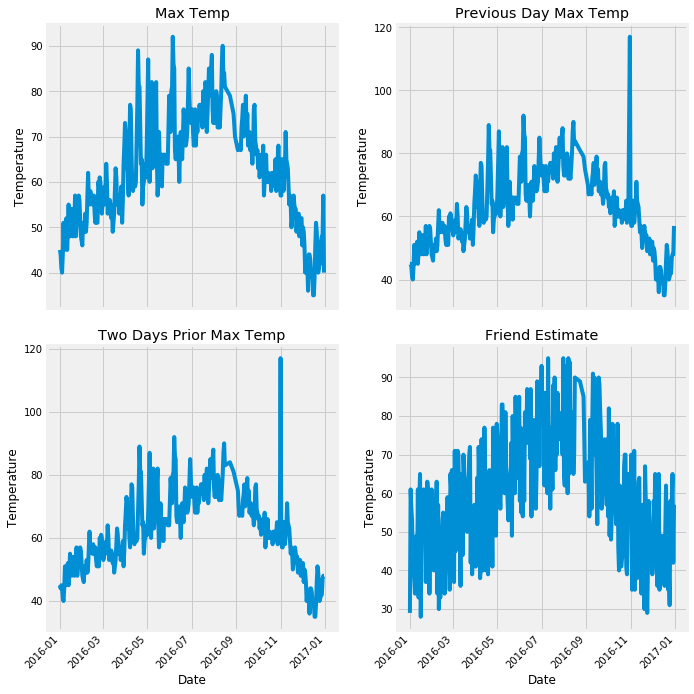

In [8]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# Actual max temperature measurement
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Day Max Temp')

# Temperature from 2 days ago
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# Friend Estimate
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

### 2.2 One-Hot Encoding

#### Takes categorical variables, such as days of the week and converts it to a numerical representation without an arbitrary ordering. 

- Days of the week are intuitive to us because we use them all the time. 

- You will (hopefully) never find anyone who doesn’t know that ‘Mon’ refers to the first day of the workweek, but machines do not have any intuitive knowledge. What computers know is numbers and for machine learning we must accommodate them. We could simply map days of the week to numbers 1–7, but this might lead to the algorithm placing more importance on Sunday because it has a higher numerical value.

One hot encoding takes this:

| week |
|------|
| Mon  |
| Tue  |
| Wed  |
| Thu  |
| Fri  |

and converts it into:

| Mon | Tue | Wed | Thu | Fri |
|-----|-----|-----|-----|-----|
| 1   | 0   | 0   | 0   | 0   |
| 0   | 1   | 0   | 0   | 0   |
| 0   | 0   | 1   | 0   | 0   |
| 0   | 0   | 0   | 1   | 0   |
| 0   | 0   | 0   | 0   | 1   |

In [22]:
# One-hot encode categorical features
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [23]:
print('Shape of features after one-hot encoding:', features.shape)

Shape of features after one-hot encoding: (348, 15)


### 2.3 Convert Features and Labels and Convert Data to Arrays

#### 1) Separate the data into features and targets. 

The target, also known as the label, is the value we want to predict, in this case the actual max temperature and the features are all the columns the model uses to make a prediction. 

#### 2) We will also convert the Pandas dataframes to Numpy arrays 

because that is the way the algorithm works. (save the column headers, which are the names of the features, to a list to use for later visualization).

In [9]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(features['actual'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('actual', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

### 2.4 Split the data into Training and Testing Sets

In [13]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [14]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (261, 8)
Training Labels Shape: (261,)
Testing Features Shape: (87, 8)
Testing Labels Shape: (87,)


# 3. Simple Baseline Predictions - Average

Before we can make and evaluate predictions, we need to establish a baseline, a sensible measure that we hope to beat with our model. 

If our model cannot improve upon the baseline, then it will be a failure and we should try a different model or admit that machine learning is not right for our problem. 

**The baseline prediction for our case can be the historical max temperature averages.**

In other words, our baseline is the error we would get if we simply predicted the average max temperature for all days.

In [15]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('average')]

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'degrees.')

Average baseline error:  5.06 degrees.


### Now, let us target to build a model with error less than our base line which is 5.06 degrees

# 4. Train Model

We import the random forest regression model from skicit-learn, instantiate the model, and fit (scikit-learn’s name for training) the model on the training data. (setting the random state for reproducible results).

In [17]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model - 100 trees
rf = RandomForestRegressor(n_estimators= 100, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels)

# 5. Make Predictions on Test Data

Our model has now been trained to learn the relationships between the features and the targets. The next step is figuring out how good the model is! To do this we make predictions on the test features (the model is never allowed to see the test answers). 

We then compare the predictions to the known answers. When performing regression, we need to make sure to use the absolute error because we expect some of our answers to be low and some to be high. 

In [31]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 3.83 degrees.


###  Model Error = 3.83 degrees < Base Line Error = 5.06 degrees

##### It is nearly 25% better than the baseline...Still we may not be happy

# 6. Determine Performance Metrics

In [33]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.98 %.


# 7. Improve Model - Tuning

We can create models with different hyperparameters to try and boost performance. The only way to find the best ones
are to try a few and evaluate them! 

In [34]:
rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, 
                               min_samples_split = 2, min_samples_leaf = 1)

# 8. Interpret Model Results - Visualizing

At this point, we know our model is good, but it’s pretty much a black box. We feed in some Numpy arrays for training, ask it to make a prediction, evaluate the predictions, and see that they are reasonable. 

The question is: how does this model arrive at the values? 

There are two approaches to get under the hood of the random forest: 
- first, we can look at a single tree in the forest, 

- second, we can look at the feature importances of our explanatory variables.

### 8.1 Visualizing a Single Decision Tree

It requires pydot. Install it.

```bash
$ pip install pydot
```

we can actually examine any of the trees in the forest. We will select one tree, and save the whole tree as an image.

In [36]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png'); 

#### View this tree in another tab...if it can't show here..

![Decision Tree](tree.png)

In [37]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 15


Smaller tree for visualization.

In [39]:
# Limit depth of tree to 2 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=42)
rf_small.fit(train_features, train_labels)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png');

#### smaller tree

![Small Decision Tree](images/small_tree.PNG)

### Annotated Version of Tree

![Annotated Decision Tree](images/small_tree_annotated.PNG)

Based solely on this tree, we can make a prediction for any new data point. Let’s take an example of making a prediction for Wednesday, December 27, 2017. The (actual) variables are: temp_2 = 39, temp_1 = 35, average = 44, and friend = 30. We start at the root node and the first answer is True because temp_1 ≤ 59.5. We move to the left and encounter the second question, which is also True as average ≤ 46.8. Move down to the left and on to the third and final question which is True as well because temp_1 ≤ 44.5. Therefore, we conclude that our estimate for the maximum temperature is 41.0 degrees as indicated by the value in the leaf node. An interesting observation is that in the root node, there are only 162 samples despite there being 261 training data points. This is because each tree in the forest is trained on a random subset of the data points with replacement (called bagging, short for bootstrap aggregating). (We can turn off the sampling with replacement and use all the data points by setting bootstrap = False when making the forest). Random sampling of data points, combined with random sampling of a subset of the features at each node of the tree, is why the model is called a ‘random’ forest.

Furthermore, notice that in our tree, there are only 2 variables we actually used to make a prediction! According to this particular decision tree, the rest of the features are not important for making a prediction. Month of the year, day of the month, and our friend’s prediction are utterly useless for predicting the maximum temperature tomorrow! The only important information according to our simple tree is the temperature 1 day prior and the historical average. 

### 8.2 Variable Importances

- In order to quantify the usefulness of all the variables in the entire random forest, we can look at the relative importances of the variables. 

- The importances returned in Skicit-learn represent how much including a particular variable improves the prediction.

In [40]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.69
Variable: average              Importance: 0.2
Variable: day                  Importance: 0.03
Variable: friend               Importance: 0.03
Variable: temp_2               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


- First, At the top of the list is temp_1, the max temperature of the day before. This tells us the best predictor of the max temperature for a day is the max temperature of the day before, a rather intuitive finding. 

- The second most important factor is the historical average max temperature, also not that surprising. 

- Your friend turns out to not be very helpful, along with the day of the week, the year, the month, and the temperature 2 days prior. 

- These importances all make sense as we would not expect the day of the week to be a predictor of maximum temperature as it has nothing to do with weather. 

- Moreover, the year is the same for all data points and hence provides us with no information for predicting the max temperature.

### 8.3 Model with Two Most Important Features

we can remove those variables that have no importance and the performance will not suffer. Additionally, if we are using a different model, say a support vector machine, we could use the random forest feature importances as a kind of feature selection method.

In [41]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.92 degrees.
Accuracy: 93.76 %.


This tells us that we actually do not need all the data we collected to make accurate predictions! If we were to continue using this model, we could only collect the two variables and achieve nearly the same performance. In a production setting, we would need to weigh the decrease in accuracy versus the extra time required to obtain more information. 

## 8.3 Visualizations

### 8.3.1 Variable Importances

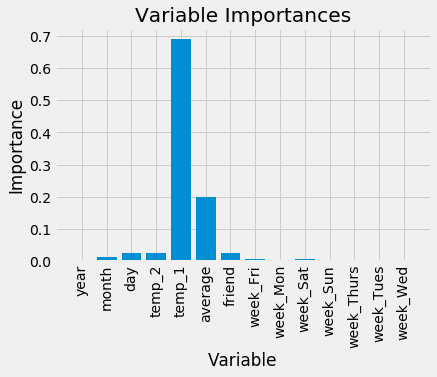

In [42]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

### 8.3.2. Predictions and Actual Values

we can plot the entire dataset with predictions highlighted. This requires a little data manipulation, but its not too difficult. We can use this plot to determine if there are any outliers in either the data or our predictions.

In [43]:
# Dates of training values
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Dates of predictions
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions}) 

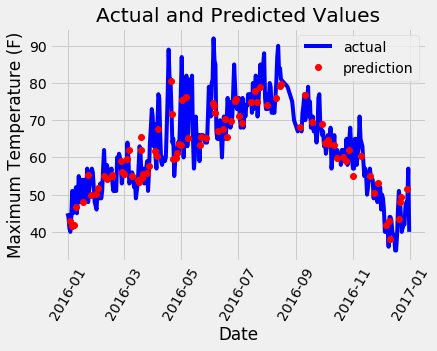

In [44]:
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');


### Targets and Data Visualization

The previous graph doesn’t look as if we have any noticeable outliers that need to be corrected. To further diagnose the model, we can plot residuals (the errors) to see if our model has a tendency to over-predict or under-predict, and we can also see if the residuals are normally distributed. However, I will just make one final chart showing the actual values, the temperature one day previous, the historical average, and our friend’s prediction. This will allow us to see the difference between useful variables and those that aren’t so helpful.

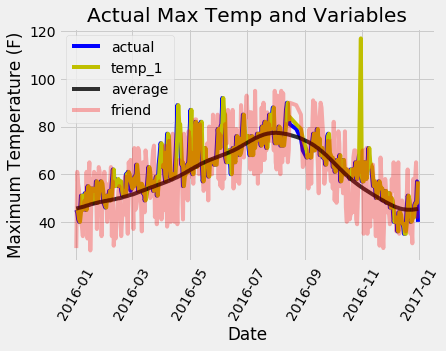

In [45]:
# Make the data accessible for plotting
true_data['temp_1'] = features[:, feature_list.index('temp_1')]
true_data['average'] = features[:, feature_list.index('average')]
true_data['friend'] = features[:, feature_list.index('friend')]

# Plot all the data as lines
plt.plot(true_data['date'], true_data['actual'], 'b-', label  = 'actual', alpha = 1.0)
plt.plot(true_data['date'], true_data['temp_1'], 'y-', label  = 'temp_1', alpha = 1.0)
plt.plot(true_data['date'], true_data['average'], 'k-', label = 'average', alpha = 0.8)
plt.plot(true_data['date'], true_data['friend'], 'r-', label = 'friend', alpha = 0.3)

# Formatting plot
plt.legend(); plt.xticks(rotation = '60');

# Lables and title
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');

we can see why the max temperature one day prior and the historical max temperature are useful for predicting max temperature while our friend is not

## TODO

- Experiments to Compute the trade-off - Accuracy vs Runtime

- Try other Algorithms such as SVM for regression and compare the results

- Hyper paramter tuning - Explore different methods and compare the results
